In [7]:
#Import libraries
import pandas as pd # CSV file I/O (pd.read_csv)
import numpy as np #linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures
#Import data
gini = pd.read_csv('gini.csv')
prod = pd.read_csv('Productivity.csv')

In [8]:
#Cleaning the data
gini.drop(['Country Code'],axis=1,inplace=True)
gini.columns.values[0]='Country'
gini.columns.values[2]='Gini'
prod = prod.drop(['LOCATION','TIME','Subject', 'Unit','Unit Code','MEASURE','Measure','PowerCode','Reference Period Code','Reference Period', 'PowerCode Code','Flag Codes', 'Flags'], axis=1)
prod = prod[prod.Country != 'G7']
prod = prod[prod.Country != 'BRIICS economies - Brazil, Russia, India, Indonesia, China and South Africa']
prod = prod[prod.Country != 'OECD - Total']
prod = prod[prod.Country != 'Euro area (19 countries)']
prod = prod[prod.Country != 'European Union (28 countries)']
prod.replace("China (People's Republic of)","China",inplace=True)
gini.replace("Russian Federation","Russia",inplace=True)
gini.replace("Korea, Rep.","Korea",inplace=True)

In [9]:
#Confirming absence of null values
gini.isnull().any().sum() + prod.isnull().any().sum()

0

In [10]:
prod_gdpemp = prod[prod['SUBJECT'] == 'T_GDPEMP'] #GDP per person employed
prod_gdppop = prod[prod['SUBJECT'] == 'T_GDPPOP'] #GDP per head of population
prod_gdphrs = prod[prod['SUBJECT'] == 'T_GDPHRS'] #GDP per hour worked

In [11]:
def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 
gdpemp_countries = prod_gdpemp['Country'].unique().tolist()
gini_countries = gini['Country'].unique().tolist()
countries = intersection(gdpemp_countries, gini_countries)
countries
#countries that can be analyzed by inclusion in Gini and Productivity set

['Australia',
 'Austria',
 'Belgium',
 'Canada',
 'Czech Republic',
 'Denmark',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Japan',
 'Korea',
 'Luxembourg',
 'Mexico',
 'Netherlands',
 'Norway',
 'Poland',
 'Portugal',
 'Slovak Republic',
 'Spain',
 'Sweden',
 'Switzerland',
 'Turkey',
 'United Kingdom',
 'United States',
 'Brazil',
 'Chile',
 'China',
 'Estonia',
 'India',
 'Indonesia',
 'Israel',
 'Russia',
 'Slovenia',
 'South Africa',
 'Colombia',
 'Latvia',
 'Lithuania']

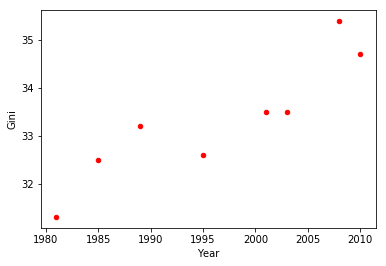

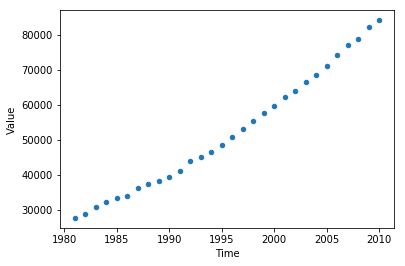

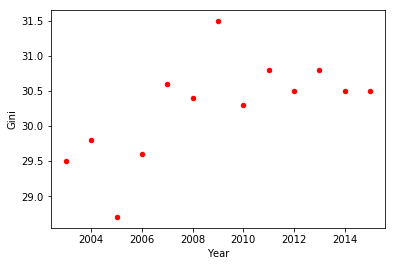

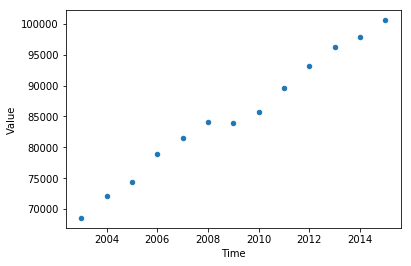

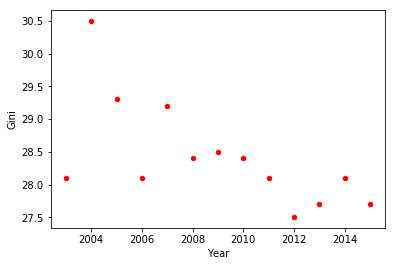

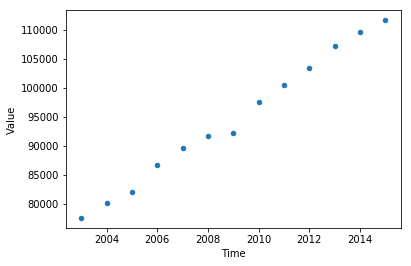

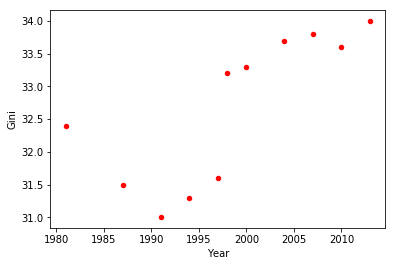

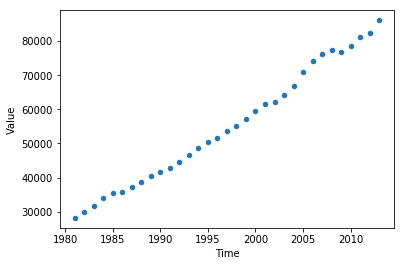

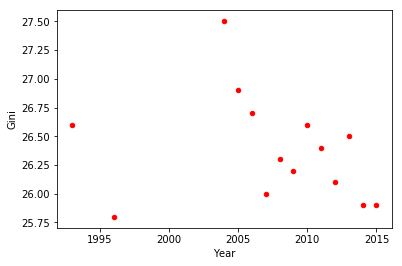

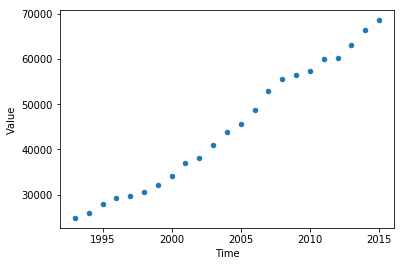

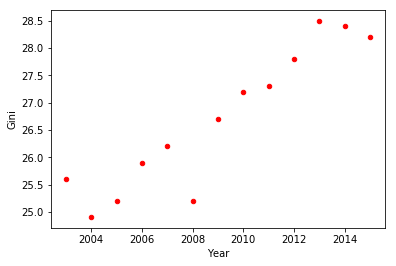

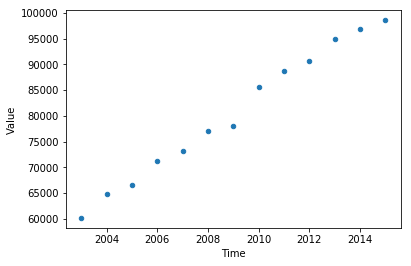

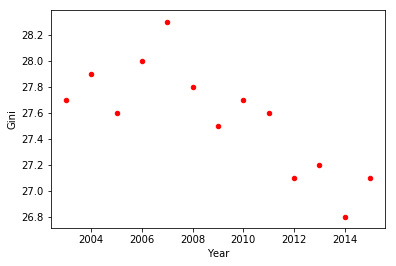

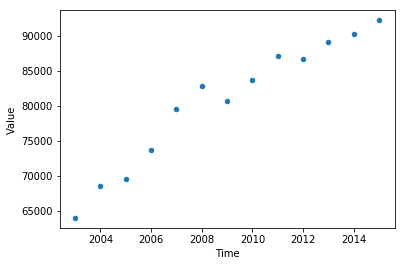

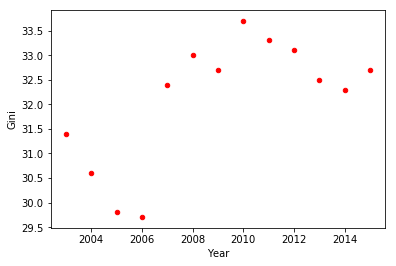

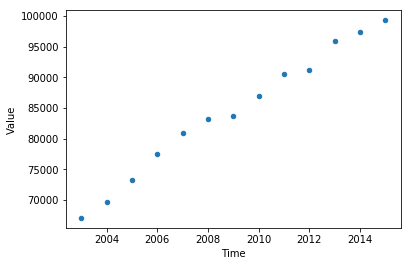

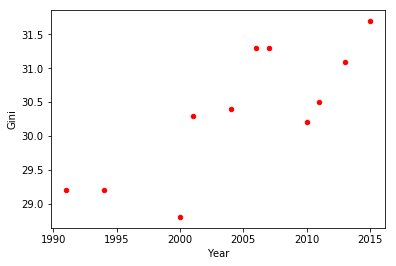

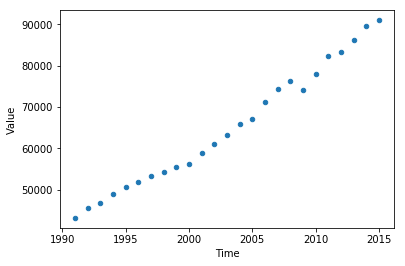

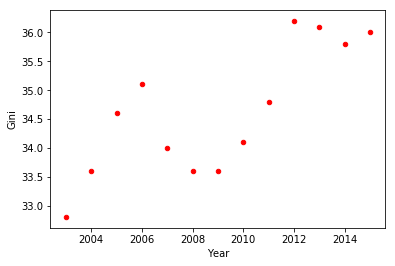

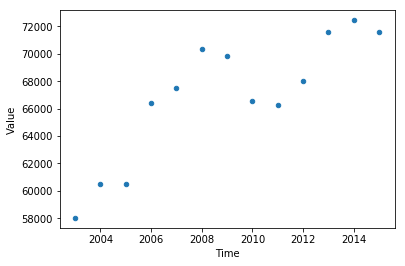

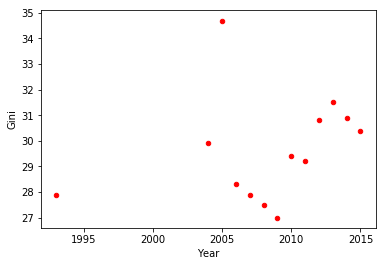

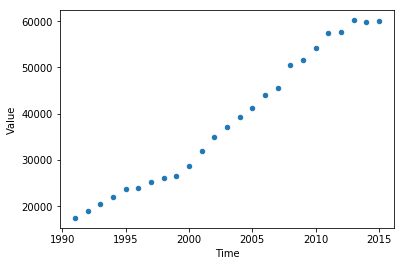

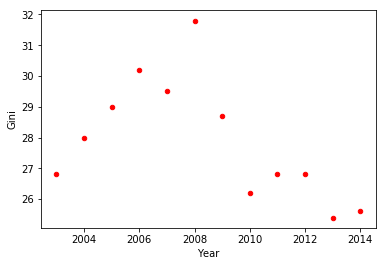

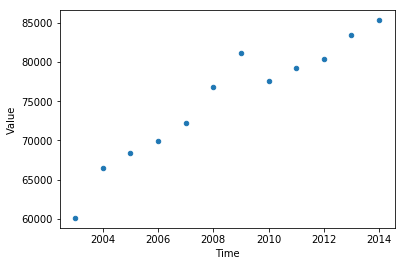

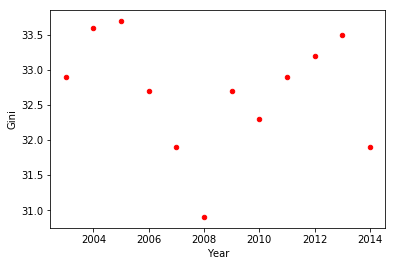

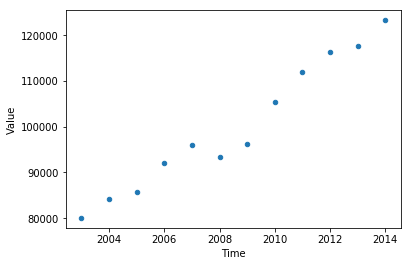

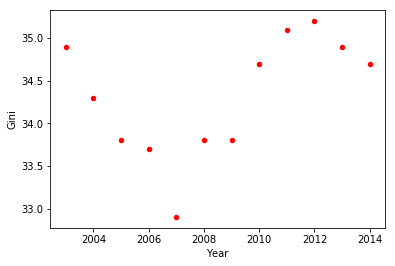

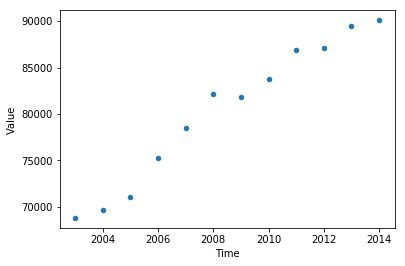

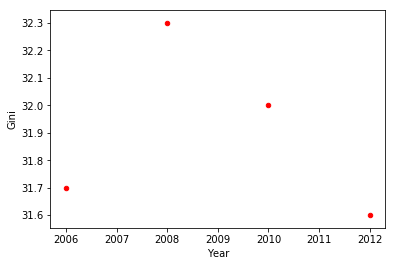

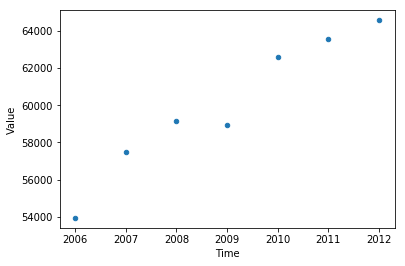

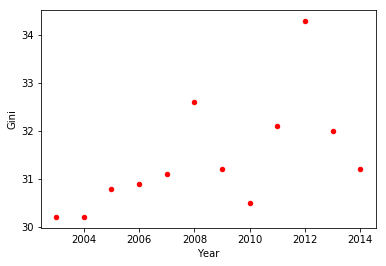

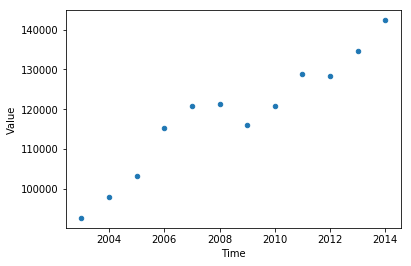

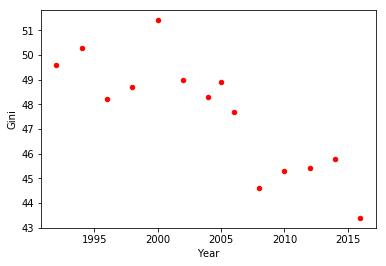

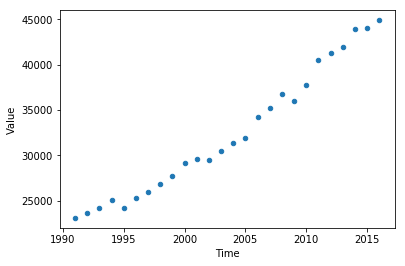

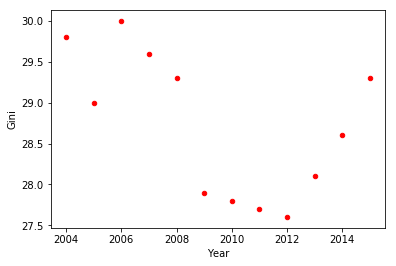

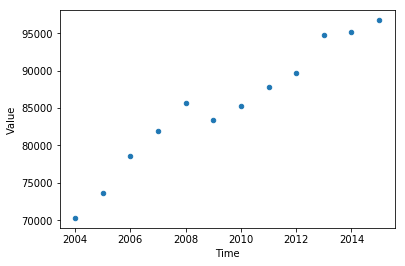

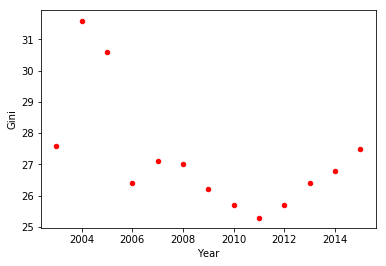

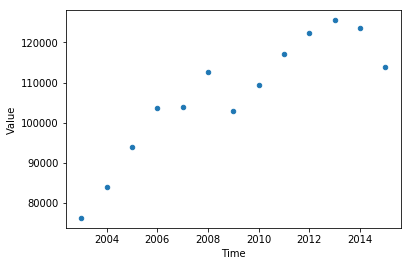

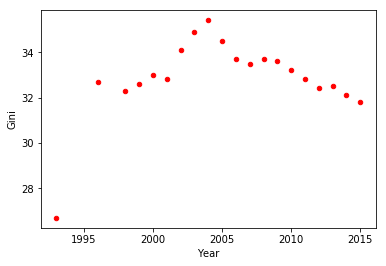

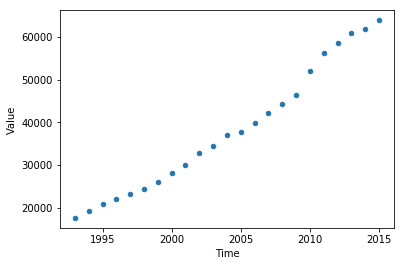

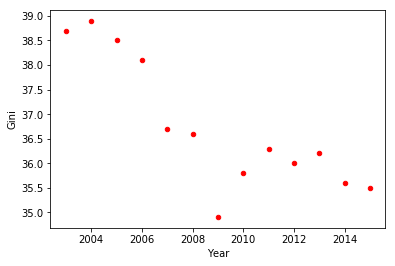

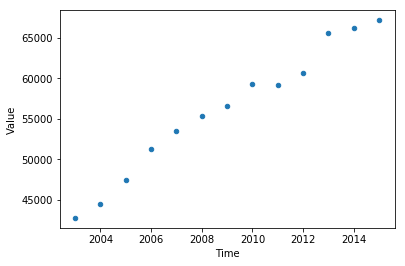

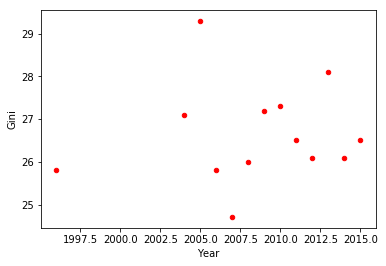

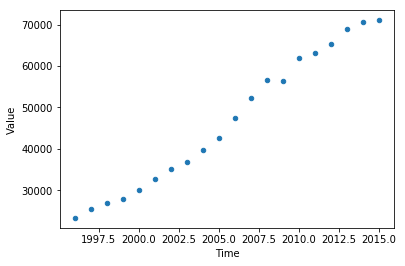

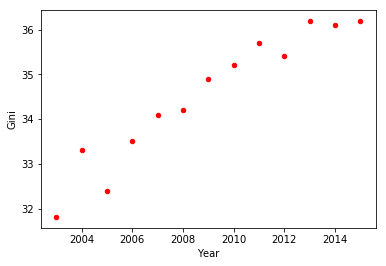

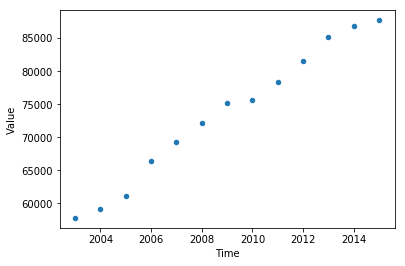

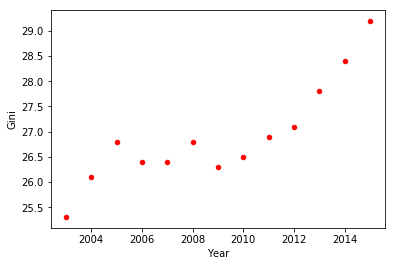

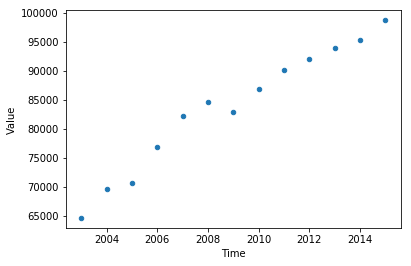

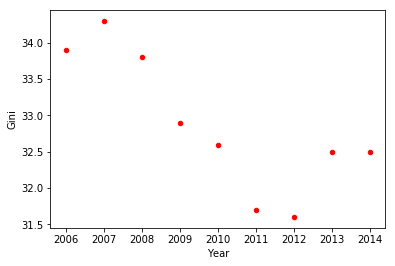

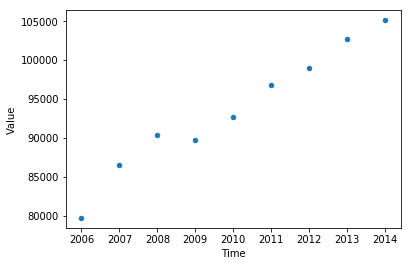

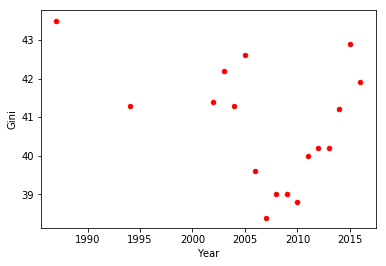

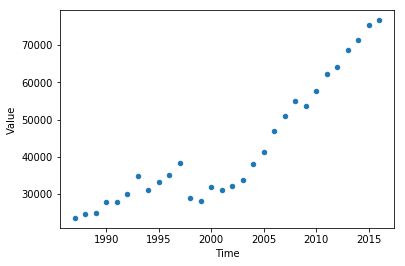

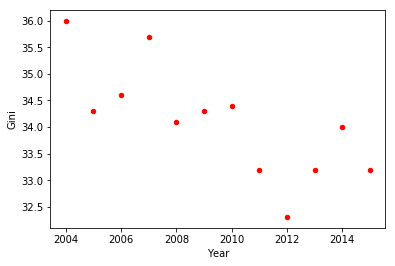

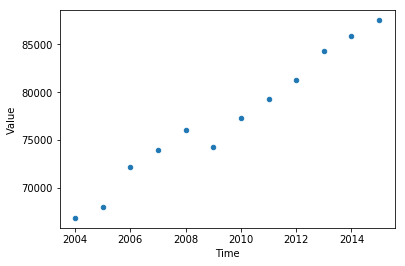

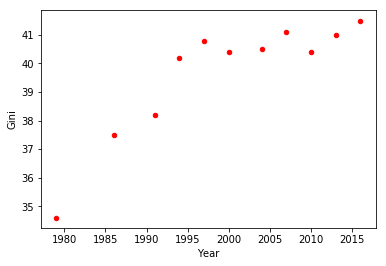

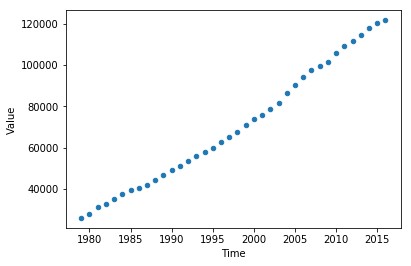

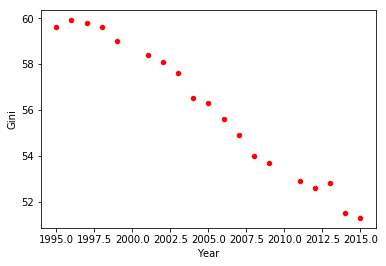

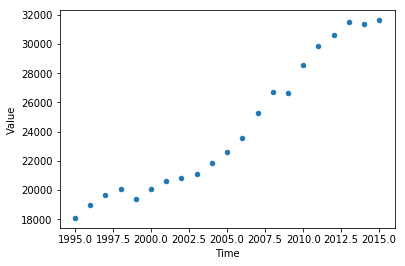

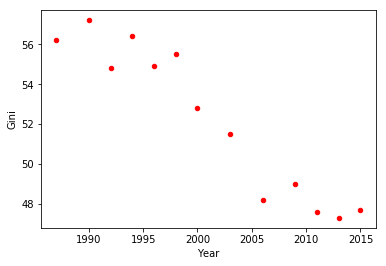

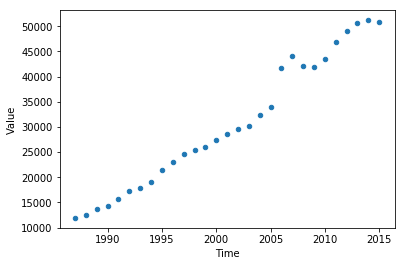

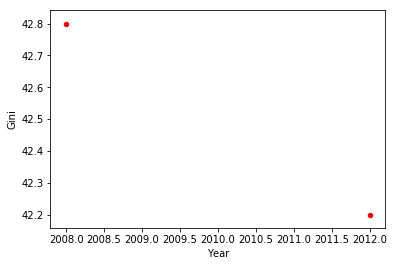

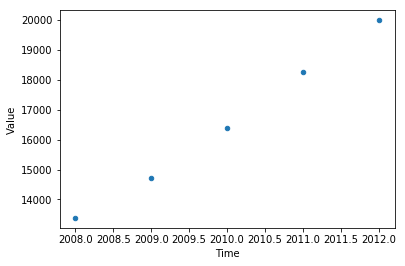

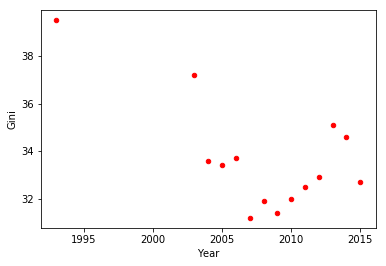

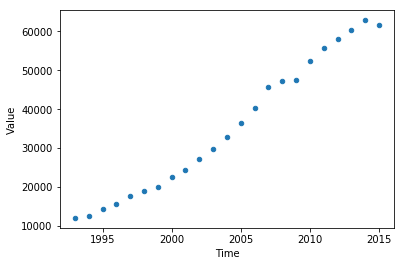

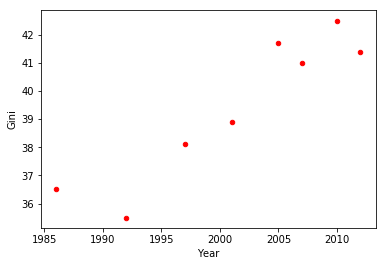

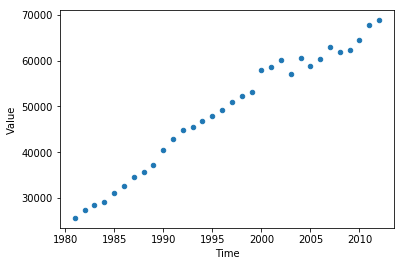

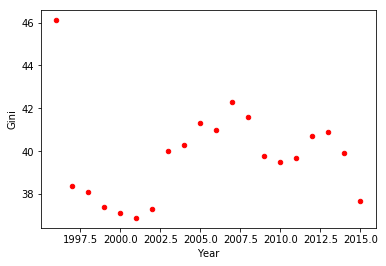

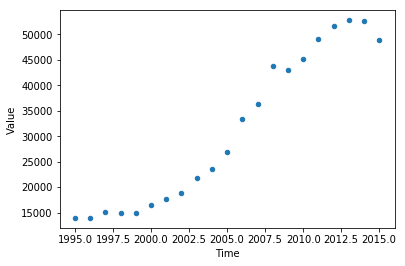

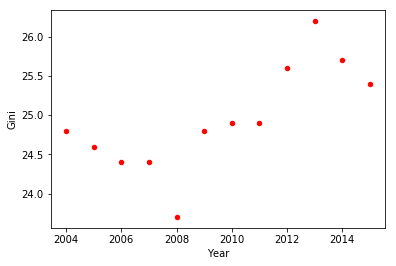

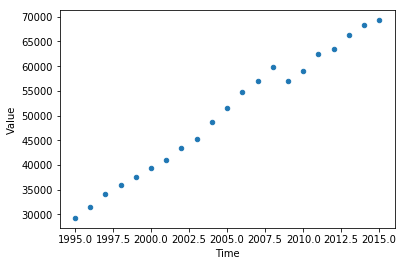

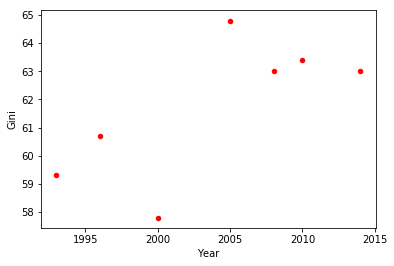

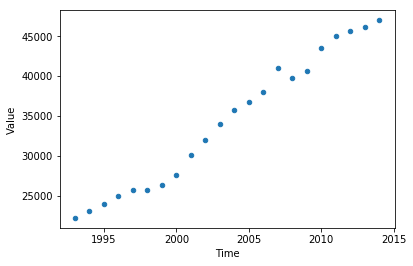

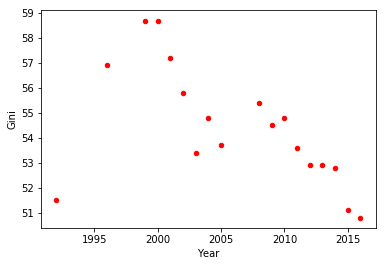

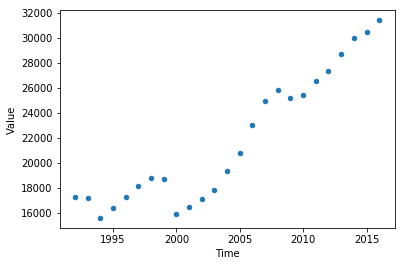

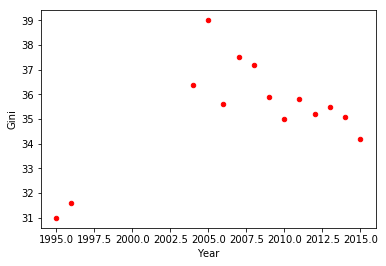

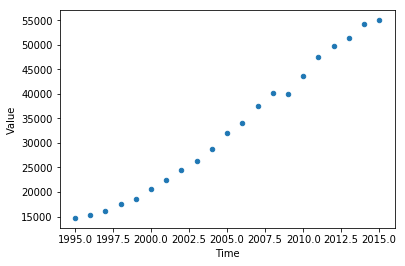

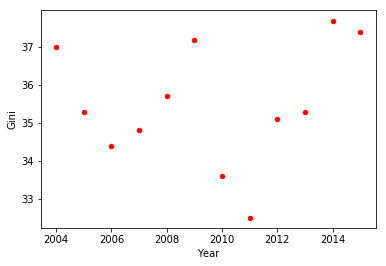

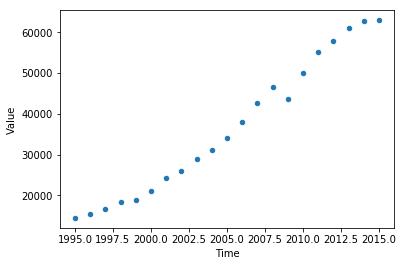

In [12]:
import warnings; warnings.simplefilter('ignore')

for i in countries:
    pyear = prod_gdpemp[prod_gdpemp.Country == i]
    pyear_min = pyear.Time.values[0]
    pyear_max = pyear.Time.values[len(pyear)-1]
    gyear = gini[gini.Country == i]
    gyear_min = gyear.Year.values[0]
    gyear_max = gyear.Year.values[len(gyear)-1]
    #if-else???
    minyear = gyear_min
    if(gyear_min < pyear_min):
        minyear = pyear_min
    maxyear = gyear_max
    if(gyear_max > pyear_max):
        maxyear = pyear_max
    if(minyear - maxyear != 0):
        gini[gini['Country'] == i][gini['Year'] <= maxyear][gini['Year'] >= minyear].plot(kind='scatter',x='Year',y='Gini',color='red')
        plt.show()
        prod_gdpemp[prod_gdpemp['Country'] == i][prod_gdpemp['Time'] <= maxyear][prod_gdpemp['Time'] >= minyear].plot(kind='scatter',x='Time', y='Value')
        plt.show()

At this juncture, we have correctly joined the data in Countries. Clearly, there is far more information in prod_gdpemp every time, but there are certainly years in gini that do not appear in prod_gdpemp as well. The fundamental question to compare correlation is to realize that both sets must be imputed upon. That is, for all years in Gini not in Prod, there must be say, m=5 imputations and vice-a-versa. And how? 

A cubic regression seems appropriate to begin. There are some gini datasets with only two or three points. 

In pseudocode: do polynomial regression Gini for each year (in Prod not in Gini) and m-imputate the data
               do polynomial regression Prod for each year (in Gini not in Prod) and m-imputate the data
               Perform the Pearson correlation coefficient on the data with random variables
               Averaging all the Pearson correlations will yield the final result:
                   *Does the Gini coefficient correlate to Productivity?*